# GAN

GANでMNISTを生成する。  
DeepConvolutionalじゃないGAN。なるべくシンプルな実装を目指す。

In [100]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
# import torchvision
# from torchvision.datasets import MNIST
# from torchvision import transforms
from IPython.display import display

batch_size = 64 # バッチサイズ
nz = 10000 # 潜在変数の次元数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## MNIST

In [2]:
dataset = MNIST(
    root="datasets/",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True # バッチサイズがずれると面倒くさいので最後は切り捨て
)

# sample_x, _ = next(iter(dataloader))
# w, h = sample_x.shape[2:]
# image_size = w * h
print("batch shape:", sample_x.shape)
print("width:", w)
print("height:", h)
print("image size:", image_size)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting datasets/MNIST/raw/train-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting datasets/MNIST/raw/train-labels-idx1-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%


Extracting datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to datasets/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100.0%

Extracting datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to datasets/MNIST/raw

batch shape: torch.Size([64, 1, 28, 28])
width: 28
height: 28
image size: 784


## Discriminator

全結合とReLUで構築

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._linear_dropout_relu(1, 512), # ある値を見て判断するので1次元
            self._linear_dropout_relu(512, 1024),
            self._linear_relu(1024, 512),
            self._linear_relu(512, 256),
            self._linear_relu(256, 3),
            nn.BatchNorm1d(3),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )
    
    def _linear_dropout_relu(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.Dropout(0.5),
            nn.ReLU()
        )
    
    def _linear_relu(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU()
        )

    # 入力は出力値
    def forward(self, x):
        y = self.net(x)
        return y # 3クラスそれぞれの確率がベクトルとして出力される

## Generator

全結合とReLUとバッチ正規化で構築

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self._linear_relu(nz, 128),
            self._linear_relu(128, 256),
            self._linear_relu(256, 512),
            self._linear(512, nz), # 最後に入力と同じサイズの偽の出力を生成
        )

    def _linear(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )
    
    def _linear_relu(self, input_size, output_size):
        return nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.ReLU()
        )

    def forward(self, x):
        y = self.net(x)
        return y

## 学習

In [5]:
# ノイズを生成
def make_noise(batch_size):
    return torch.randn(batch_size, nz, device=device) # batch_size * nzの行列を生成

# 画像描画
# def write(netG, n_rows=1, n_cols=8, size=64):
#     z = make_noise(n_rows*n_cols)
#     images = netG(z)
#     images = transforms.Resize(size)(images)
#     img = torchvision.utils.make_grid(images, n_cols)
#     img = transforms.functional.to_pil_image(img)
#     display(img)

今回は本物を0, 偽物を1とする。  
Generatorが生成した偽物をDiscriminatorで判定したときに0になるように学習する。

**0に近づきたい = 小さくしたい** と捉えられるので、Discriminatorの出力をそのまま**損失**として扱って逆伝播を行う

ただ一般的には、Discriminatorの出力を交差エントロピーに入れたものを損失として扱う。その方が損失が指数関数になるので学習が上手く進む（多分）。  
交差エントロピーを使うときは、0, 1の値はどっちでもいい。本物を1, 偽物を0とすることが多い気がする。

In [110]:
import random
import numpy as np

real_labels = torch.zeros(batch_size, 1).to(device) # 本物のラベル
fake_labels = torch.ones(batch_size, 1).to(device) # 偽物のラベル
criterion = nn.BCELoss() # 損失関数

def noisy_sum(arr, eps=0.1):
    noisy_sum = 0
    for i in range(len(arr)):
        noisy_sum += arr[i] + np.random.laplace(0, 1 / eps)
    return noisy_sum
alg = noisy_sum
a1 = [1, 3, 5, 7, 9]
a2 = [2, 4, 6, 8, 10]
sample_num = 100000
data1 = [torch.tensor([alg(a1), 1], dtype=torch.float32) for _ in range(sample_num)]
data2 = [torch.tensor([alg(a2), 2], dtype=torch.float32) for _ in range(sample_num)]
data_list = data1 + data2
print(data_list)
# print(data1[0])
# print(type(data1))
data = torch.vstack(data_list)
shuffled_data = data[torch.randperm(data.size()[0])]
print(shuffled_data[0][0])
batch_size = 10000
num_classes = 3
batches = shuffled_data.split(batch_size)

def train(netD, netG, optimD, optimG, n_epochs, write_interval=1):
    # 学習モード
    netD.train()
    netG.train()

    for epoch in range(1, n_epochs+1):
        for batch in batches:
            batch = batch.to(device)

            batch_transposed = batch.transpose(0, 1)
            real_outputs = batch_transposed[0]
            real_labels = batch_transposed[1]
            real_one_hot_labels = torch.nn.functional.one_hot(real_labels.to(torch.int64), num_classes).to(torch.float32)

            # 勾配をリセット
            optimG.zero_grad()

            # Generatorの学習
            batch_size = 2
            z = make_noise(batch_size) # ノイズを生成
            # print(z)
            fake = netG(z) # 偽物を生成 偽物がnz=10000だけ生成される
            # print(fake)
            pred_fake = netD(fake[:-1].T) # 偽物を判定, nzの数のデータのそれぞれのクラスの確率が出力される
            # class_1_or_2 = pred_fake[:, 0] # 偽物であると判断する確率（これを小さくしたい）
            # loss_fake = class_1_or_2.sum() # 偽物の判定に対する誤差
            # lossG = loss_fake # + loss_real # 二つの誤差の和
            lossG = criterion(pred_fake, real_one_hot_labels)
            lossG.backward() # 逆伝播
            optimG.step() # パラメータ更新

            # 出力bと正解ラベルの用意
            batch_transposed = batch.transpose(0, 1)
            real_outputs = batch_transposed[0]
            real_labels = batch_transposed[1]
            real_one_hot_labels = torch.nn.functional.one_hot(real_labels.to(torch.int64), num_classes).to(torch.float32)
            fake = netG(z)
            fake_labels = torch.zeros_like(fake[0])
            fake_one_hot_labels = torch.nn.functional.one_hot(fake_labels.to(torch.int64), num_classes).to(torch.float32)

            # Discriminatorの学習
            optimD.zero_grad()
            pred_real = netD(real_outputs.unsqueeze(1))
            pred_fake = netD(fake[:-1].T)
            loss_real = criterion(pred_real, real_one_hot_labels)
            loss_fake = criterion(pred_fake, fake_one_hot_labels)
            lossD = loss_real + loss_fake
            lossD.backward()
            for name, param in netD.named_parameters():
                if param.grad is not None:
                    print(f"勾配が計算されました: {name}, grad: {param.grad}")
                else:
                    print(f"勾配が計算されていません: {name}")
            optimD.step()

        print(f'{epoch:>3}epoch | lossD: {lossD:.4f}, lossG: {lossG:.4f}')
        # if epoch % write_interval == 0:
        #     write(netG)

[tensor([17.0210,  1.0000]), tensor([-31.1446,   1.0000]), tensor([72.0262,  1.0000]), tensor([39.9687,  1.0000]), tensor([-8.3524,  1.0000]), tensor([96.7997,  1.0000]), tensor([3.6572, 1.0000]), tensor([25.0433,  1.0000]), tensor([49.8338,  1.0000]), tensor([-22.4244,   1.0000]), tensor([49.4518,  1.0000]), tensor([42.5093,  1.0000]), tensor([13.1807,  1.0000]), tensor([18.3788,  1.0000]), tensor([65.8997,  1.0000]), tensor([61.9423,  1.0000]), tensor([49.1507,  1.0000]), tensor([81.4569,  1.0000]), tensor([16.5671,  1.0000]), tensor([84.3356,  1.0000]), tensor([27.4541,  1.0000]), tensor([-15.4611,   1.0000]), tensor([-6.8224,  1.0000]), tensor([-42.2109,   1.0000]), tensor([23.7151,  1.0000]), tensor([118.9309,   1.0000]), tensor([-28.7972,   1.0000]), tensor([12.3716,  1.0000]), tensor([1.6419, 1.0000]), tensor([39.2634,  1.0000]), tensor([50.8856,  1.0000]), tensor([25.0132,  1.0000]), tensor([21.4652,  1.0000]), tensor([-5.4084,  1.0000]), tensor([64.3623,  1.0000]), tensor([53.

In [111]:
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)
n_epochs = 5

print('初期状態')
train(netD, netG, optimD, optimG, 30)

初期状態
勾配が計算されました: net.0.0.weight, grad: tensor([[-4.4788e-04],
        [ 1.6099e-04],
        [ 3.4966e-03],
        [ 6.8460e-04],
        [ 9.1172e-04],
        [-5.2313e-04],
        [ 1.0609e-03],
        [-1.8696e-03],
        [-5.0140e-04],
        [-1.1974e-03],
        [ 3.0975e-04],
        [-5.9323e-05],
        [-3.0639e-04],
        [ 1.6726e-03],
        [-2.0304e-04],
        [ 9.0394e-04],
        [ 2.0780e-03],
        [ 2.1859e-03],
        [-1.7097e-04],
        [ 5.5997e-04],
        [-1.8658e-03],
        [-5.8181e-04],
        [ 4.5480e-04],
        [ 1.9895e-03],
        [ 2.9293e-03],
        [ 1.4811e-03],
        [ 2.2332e-03],
        [-1.7265e-03],
        [-2.3739e-03],
        [ 1.1876e-03],
        [ 7.5518e-04],
        [-3.5877e-04],
        [-4.7652e-05],
        [-1.3261e-04],
        [ 2.6401e-04],
        [ 1.2684e-04],
        [ 1.8568e-03],
        [-4.7863e-04],
        [-2.6722e-03],
        [ 3.5312e-05],
        [ 3.8977e-04],
        [-1.7834e-

KeyboardInterrupt: 

In [97]:
n_test = 100000
b1 = torch.tensor([alg(a1) for _ in range(n_test)])
b2 = torch.tensor([alg(a2) for _ in range(n_test)])
b1 = b1.unsqueeze(1)
b2 = b2.unsqueeze(1)
prod1 = netD(b1)
prod2 = netD(b2)
count1 = (prod1[:, 1] >= 0.5).sum()
count2 = (prod2[:, 2] >= 0.5).sum()
print(count1, count2)
eps = torch.log(count1/count2) if count1 > count2 else torch.log(count2/count1)
print(eps)

tensor(0) tensor(0)
tensor(nan)


いい感じに成長していそうなので、このまま30回学習させる

  1epoch | lossD: 0.2416, lossG: 62.8680
  2epoch | lossD: 0.1250, lossG: 59.7507
  3epoch | lossD: 0.3074, lossG: 59.3209
  4epoch | lossD: 0.5935, lossG: 56.5133
  5epoch | lossD: 0.5231, lossG: 57.6579


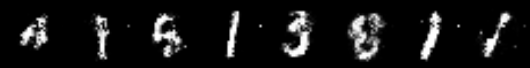

  6epoch | lossD: 0.5117, lossG: 55.2648
  7epoch | lossD: 0.5790, lossG: 52.5823
  8epoch | lossD: 0.4455, lossG: 55.9752
  9epoch | lossD: 0.5311, lossG: 51.5599
 10epoch | lossD: 0.5470, lossG: 54.6150


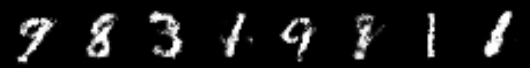

 11epoch | lossD: 0.7770, lossG: 51.4467
 12epoch | lossD: 0.8601, lossG: 51.1259
 13epoch | lossD: 0.7611, lossG: 47.6763
 14epoch | lossD: 0.7420, lossG: 49.3983
 15epoch | lossD: 0.8564, lossG: 46.7528


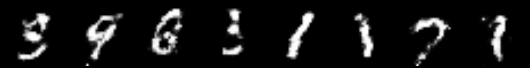

 16epoch | lossD: 0.8012, lossG: 49.5253
 17epoch | lossD: 0.7346, lossG: 50.9765
 18epoch | lossD: 0.6939, lossG: 48.5841
 19epoch | lossD: 0.7707, lossG: 45.1114
 20epoch | lossD: 0.9751, lossG: 47.5526


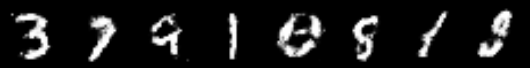

In [10]:
train(netD, netG, optimD, optimG, 20, write_interval=5)

学習完了。結果はこうなった↑。

もう少したくさん見てみる

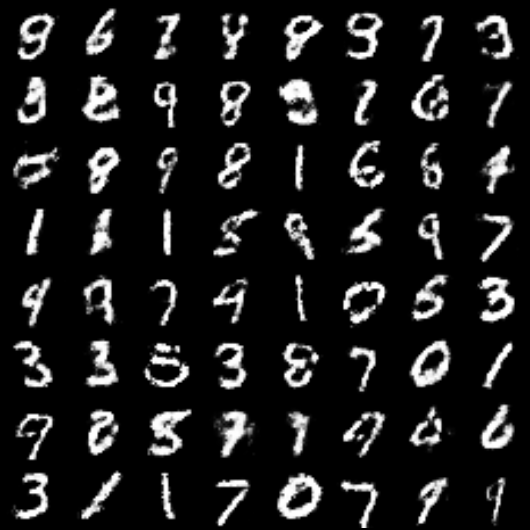

In [22]:
write(netG, 8)

上手く学習できた